# Trading Intensity

## Import dependencies

In [17]:
import pandas as pd
import numpy as np
import random
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from tqdm import tqdm

## Import data

In [18]:
header = ['trade_id','price','quantity','order_id','timestamp','is_buyer_maker']
btc_05_31_df = pd.read_csv('./Data/BTCUSDT-trades-2023-05-26.csv',header=0 , names = header)
btc_05_31_df.head()

,trade_id,price,quantity,order_id,timestamp,is_buyer_maker
0,3751246457,26461.7,0.041,1084.9297,1685059200171,True
1,3751246458,26461.7,0.359,9499.7503,1685059200171,True
2,3751246459,26461.8,0.003,79.3854,1685059200251,False
3,3751246460,26461.8,0.002,52.9236,1685059200371,False
4,3751246461,26461.8,0.008,211.6944,1685059200407,False


## Trading intenstiy
In optimal control problem, we want to find the optimal trading qoute. and we want to control inventory risk.  
Let $q_t$ be the inventory at time $t$.

- $q_t = N^b_t - N^a_t$ where $N^b_t$ is the number of shares bought and $N^a_t$ is the number of shares sold.
- $N^b_t$ and $N^a_t$ is point process and it's intensity is $\lambda$. 


In Avellaneda's paper, the author modeled the execution probability of an agent using the following approach. 

$$
\begin{align}
\lambda(\delta) = \Lambda P(\Delta p >\delta)   
\\
= A \exp(-k \delta)
\end{align}
$$

In [19]:
def probability_over_delta(df, time_delta, max_price):

    cnt = 0
    times = df['timestamp'].to_numpy()
    prices = df['price'].to_numpy()
    is_buyer_maker = df['is_buyer_maker'].to_numpy()
    
    bid_delta_counts = np.zeros(max_price + 1)
    ask_delta_counts = np.zeros(max_price + 1)

    start_time = times[0] 
    start_price = prices[0]

    min , max = start_price ,start_price
    num_buy , num_sell = 0 , 0

    for i in range(1,len(df)-1):

        #set new time step
        if times[i] - start_time > time_delta:
            cnt += 1
            #counts update
            if start_price < max: #up
                ask_delta_counts[:int(max - start_price)] += 1
            elif start_price > min: #down
                bid_delta_counts[:int(start_price - min)] += 1

            #initialize
            start_price = prices[i]
            start_time = times[i]
            min , max = start_price , start_price
            pass
        
        now_price = prices[i]

        #min max algorithm
        if max < now_price:        
            max = now_price
        if min > now_price:
            min = now_price
        
        if is_buyer_maker[i] == True:
            num_sell += 1
        else:
            num_buy += 1
        
    return bid_delta_counts/cnt, ask_delta_counts/cnt , num_buy/cnt , num_sell/cnt

In [20]:
bid_delta_counts , ask_delta_counts , avg_buy , avg_sell = probability_over_delta(btc_05_31_df,10*1000,100)

In [21]:
print("avg sell: ",avg_sell)
print("avg buy: " , avg_buy)

avg sell:  163.59503061705135
avg buy:  158.5485162505888


Bid Fit: A = 19.823650313585734, k = 0.3070574447857926
Ask Fit: A = 45.90364615424178, k = 0.2599255154502048


/var/folders/tc/pk8_r5g56wx6w90jrt_973rc0000gn/T/ipykernel_82798/2500574342.py:6: RuntimeWarning: overflow encountered in exp
  return A * np.exp(-k * delta)
/var/folders/tc/pk8_r5g56wx6w90jrt_973rc0000gn/T/ipykernel_82798/2500574342.py:6: RuntimeWarning: overflow encountered in multiply
  return A * np.exp(-k * delta)


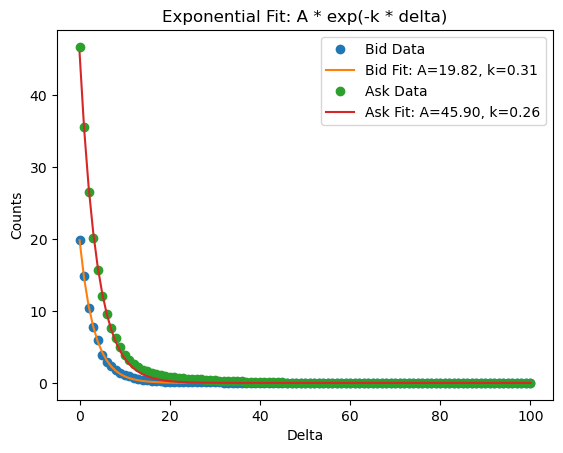

In [24]:
delta = np.arange(len(bid_delta_counts))
bid_y = bid_delta_counts * avg_buy  
ask_y = ask_delta_counts * avg_sell 

def exp_func(delta, A, k):
    return A * np.exp(-k * delta)

bid_params, bid_covariance = curve_fit(exp_func, delta, bid_y, p0=[1, 0.1])
ask_params, ask_covariance = curve_fit(exp_func, delta, ask_y, p0=[1, 0.1])

bid_A, bid_k = bid_params
ask_A, ask_k = ask_params

print(f"Bid Fit: A = {bid_A}, k = {bid_k}")
print(f"Ask Fit: A = {ask_A}, k = {ask_k}")

# 피팅된 함수 값 계산
bid_fit_y = exp_func(delta, bid_A, bid_k)
ask_fit_y = exp_func(delta, ask_A, ask_k)

# 원 데이터 및 피팅 결과 시각화
plt.plot(delta, bid_y, label="Bid Data", marker="o", linestyle="")
plt.plot(delta, bid_fit_y, label=f"Bid Fit: A={bid_A:.2f}, k={bid_k:.2f}")

plt.plot(delta, ask_y, label="Ask Data", marker="o", linestyle="")
plt.plot(delta, ask_fit_y, label=f"Ask Fit: A={ask_A:.2f}, k={ask_k:.2f}")

plt.legend()
plt.xlabel("Delta")
plt.ylabel("Counts")
plt.title("Exponential Fit: A * exp(-k * delta)")
plt.show()

In [25]:
def bid_delta(q, gamma, k, A, sigma, mu):
    return (
        (1 / gamma) * np.log(1 + gamma / k) +
        ((-mu / (gamma * sigma**2)) + (2 * q + 1) / 2) *
        np.sqrt((sigma**2 * gamma) / (2 * k * A) * (1 + gamma / k)**(1 + k / gamma))
    )

def ask_delta(q, gamma, k, A, sigma, mu):
    return (
        (1 / gamma) * np.log(1 + gamma / k) +
        ((mu / (gamma * sigma**2)) - (2 * q - 1) / 2) *
        np.sqrt((sigma**2 * gamma) / (2 * k * A) * (1 + gamma / k)**(1 + k / gamma))
    )

In [26]:
print(bid_delta(-3,0.01,1,2,8,-1))
print(ask_delta(-3,0.01,1,2,8,-1))

0.3752201383642415
2.2759798423521156


In [27]:
def closed_time_series(df, time_interval):
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df = df.set_index('timestamp')
    df['buy_quantity'] = np.where(df['is_buyer_maker'], df['quantity'], 0)
    df['sell_quantity'] = np.where(df['is_buyer_maker'], 0, df['quantity'])
    df = df.resample(str(time_interval)+'S').agg({'price':'last', 'quantity':'sum', 'buy_quantity':'sum', 'sell_quantity':'sum'})
    df['return'] = df['price'].diff()
    df = df.dropna()
    return df

In [28]:
closed_df = closed_time_series(btc_05_31_df,1)

In [29]:
def calculate_mu(data,time):
    mu = data['return'].mean() #/ (time)
    return mu

def calculate_sigma(data,time):
    sigma = data['return'].std() #/ np.sqrt(time)
    return sigma

In [30]:
mu = calculate_mu(closed_df,1/1440)
sigma = calculate_sigma(closed_df,1/1440)

In [31]:
print(mu)
print(sigma)

0.002530026295217053
1.2274733822742137


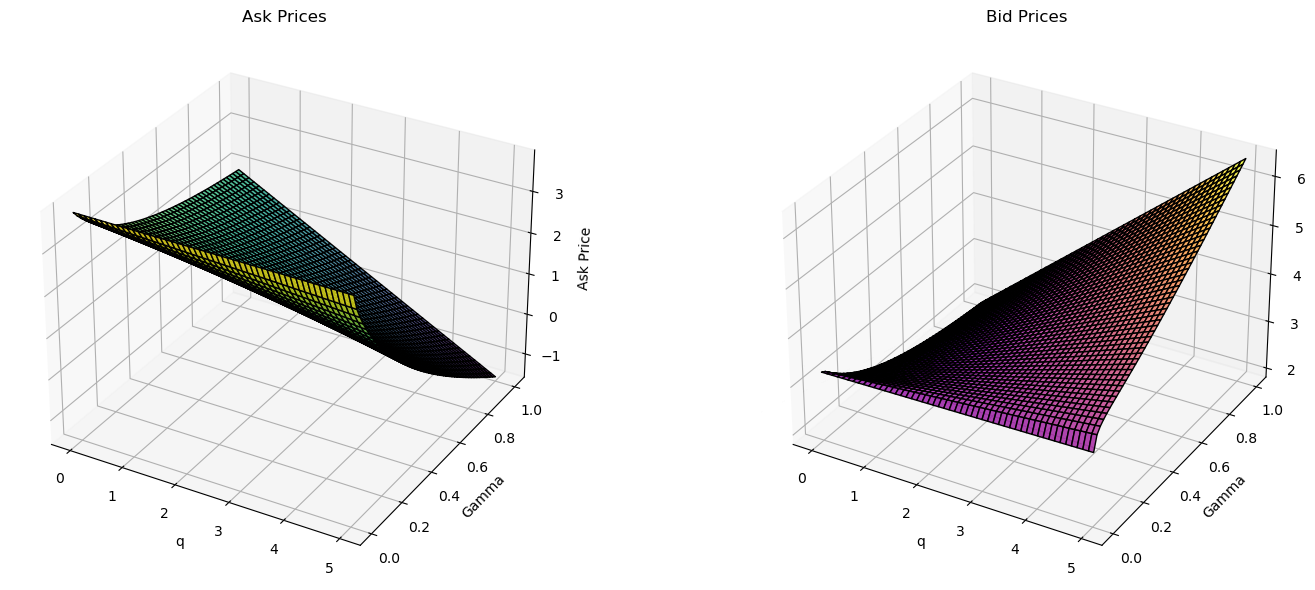

In [32]:
from mpl_toolkits.mplot3d import Axes3D

# Generate gamma values
gamma_values = np.linspace(0.001, 1, 50)

# Fixed q values
q = np.linspace(0, 5, 500)

# Initialize arrays for storing results
ask_prices = np.zeros((len(gamma_values), len(q)))
bid_prices = np.zeros((len(gamma_values), len(q)))

# Compute ask and bid prices for each gamma
for i, gamma in enumerate(gamma_values):
    ask_prices[i, :] = ask_delta(q, gamma, ask_k, ask_A, sigma, mu)
    bid_prices[i, :] = bid_delta(q, gamma, bid_k, bid_A, sigma, mu)

# Plot 3D graphs
fig = plt.figure(figsize=(16, 6))

# Ask price 3D plot
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
X, Y = np.meshgrid(q, gamma_values)
ax1.plot_surface(X, Y, ask_prices, cmap='viridis', edgecolor='k', alpha=0.8)
ax1.set_title("Ask Prices")
ax1.set_xlabel("q")
ax1.set_ylabel("Gamma")
ax1.set_zlabel("Ask Price")

# Bid price 3D plot
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.plot_surface(X, Y, bid_prices, cmap='plasma', edgecolor='k', alpha=0.8)
ax2.set_title("Bid Prices")
ax2.set_xlabel("q")
ax2.set_ylabel("Gamma")
ax2.set_zlabel("Bid Price")

plt.tight_layout()
plt.show()


## Algorithm

Let

In [143]:
def emprical_lambda_method_1(df,number_of_trials,max_tick_size,delta_t,tick_size):
    #row: number of trials , col: number of events
    timestamp = df['timestamp'].values
    price = df['price'].values
    event_list_p = np.zeros((number_of_trials,max_tick_size))
    event_list_m = np.zeros((number_of_trials,max_tick_size))
    for i in tqdm(range(1,max_tick_size)):
        for j in range(1,number_of_trials):
            time_index = random.randint(0, int(len(df)/2))
            init_time = timestamp[time_index]
            init_price = price[time_index]
            time_diff = 0
            event_count_p = 0
            while time_diff < delta_t * 1000:
                price_diff = (price[time_index] - init_price)/tick_size
                time_diff = timestamp[time_index] - init_time
                if price_diff > i:
                    event_count_p += 1
                    break ## note
                else:
                    pass 
                time_index += 1
            event_list_p[j][i] = event_count_p
    for i in range(1,max_tick_size):
        for j in range(1,number_of_trials):
            time_index = random.randint(0, int(len(df)/2))
            init_time = timestamp[time_index]
            init_price = price[time_index]
            time_diff = 0
            event_count_m = 0
            while time_diff < delta_t * 1000:
                price_diff = (price[time_index] - init_price)/tick_size
                time_diff = timestamp[time_index] - init_time
                if price_diff < -i:
                    event_count_m += 1
                    break
                else:
                    pass 
                time_index += 1
            event_list_m[j][i] = event_count_m
    mean_p = np.mean(event_list_p,axis=0)
    mean_m = np.mean(event_list_m,axis=0)
    return mean_p , mean_m

In [144]:
number_of_trials = 100
max_tick_size = 100
delta_t = 1
tick_size = 0.1

mean_p , mean_m = emprical_lambda_method_1(btc_05_31_df,number_of_trials,max_tick_size,delta_t,tick_size)

100%|██████████| 99/99 [00:00<00:00, 139.04it/s]


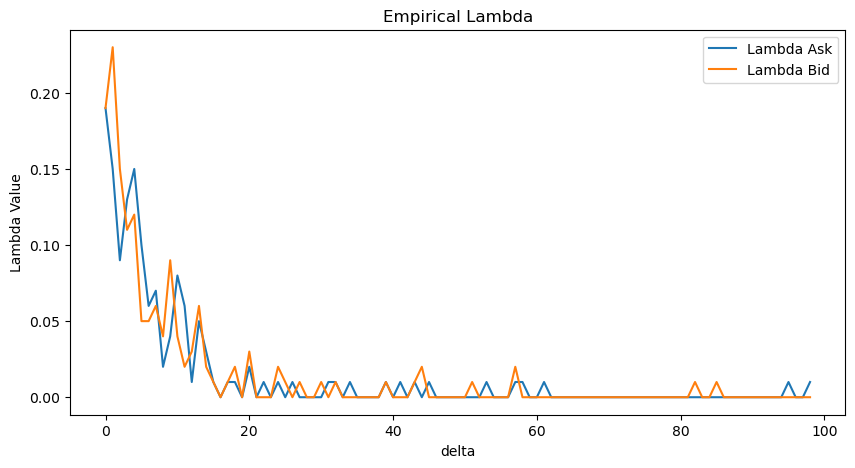

In [146]:
plt.figure(figsize=(10, 5))
plt.plot(mean_m[1:] , label='Lambda Ask')
plt.plot(mean_p[1:] , label='Lambda Bid')
plt.title('Empirical Lambda')
plt.xlabel('delta')
plt.ylabel('Lambda Value')
plt.legend()
plt.show()

In [147]:
def fit_and_plot(column_means):
    x = np.arange(len(column_means))
    y = column_means

    def exponential_func(x, A, k):
        return A * np.exp(-k * x)

    popt, pcov = curve_fit(exponential_func, x, y)

    plt.plot(x, y, 'b-', label='Data')
    plt.plot(x, exponential_func(x, *popt), 'r-', label='Fit: A=%5.3f, k=%5.3f' % tuple(popt))
    plt.xlabel('Column Index')
    plt.ylabel('Mean Value')
    plt.legend()
    plt.show()

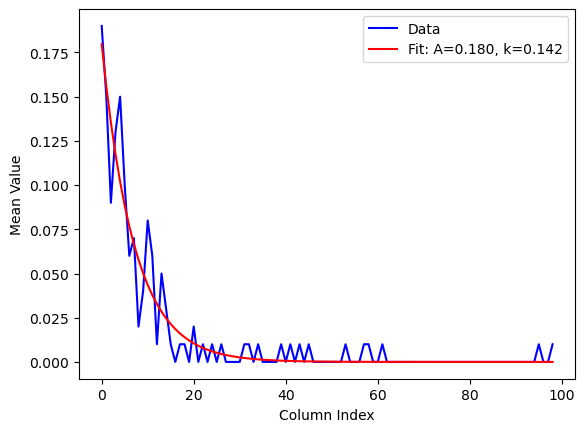

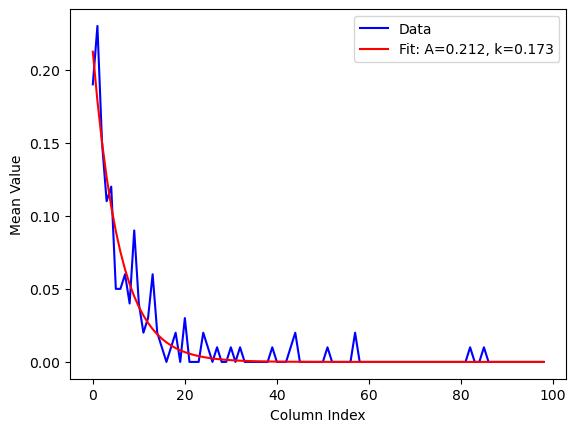

In [148]:
fit_and_plot(mean_m[1:])
fit_and_plot(mean_p[1:])

## Trading Intensity Algorithm 3
- Just count 1 tick movement 

In [122]:
#divided sell buy
sell_data = btc_05_31_df[btc_05_31_df['is_buyer_maker'] == True]
buy_data = btc_05_31_df[btc_05_31_df['is_buyer_maker'] == False]

#change
bid_diff = sell_data['price'].diff() / tick_size
ask_diff = buy_data['price'].diff() / tick_size

# count changes of ticks 
bid_unique_values, bid_counts = np.unique(bid_diff, return_counts=True)
ask_unique_values, ask_counts = np.unique(ask_diff,return_counts=True)

# Bid와 Ask 데이터에서 처음으로 0이 되는 인덱스를 찾기
start_bid = np.where(bid_unique_values == 0)[0][0]   # 처음 0이 되는 인덱스
start_ask = np.where(ask_unique_values == 0)[0][0]  # 처음 0이 되는 인덱스

# 필요한 데이터만 슬라이싱해서 사용
# print(bid_unique_values[start_bid:])
# print(bid_counts[start_bid:])
# print(ask_unique_values[start_ask:])
# print(ask_counts[start_ask:])

# # change ms to s
time_diff = (btc_05_31_df['timestamp'][len(btc_05_31_df)-1] - btc_05_31_df['timestamp'][0]).total_seconds()

# #calculate lambda per unit time (second)
lambda_bid = bid_unique_values / time_diff 
lambda_ask = ask_unique_values / time_diff

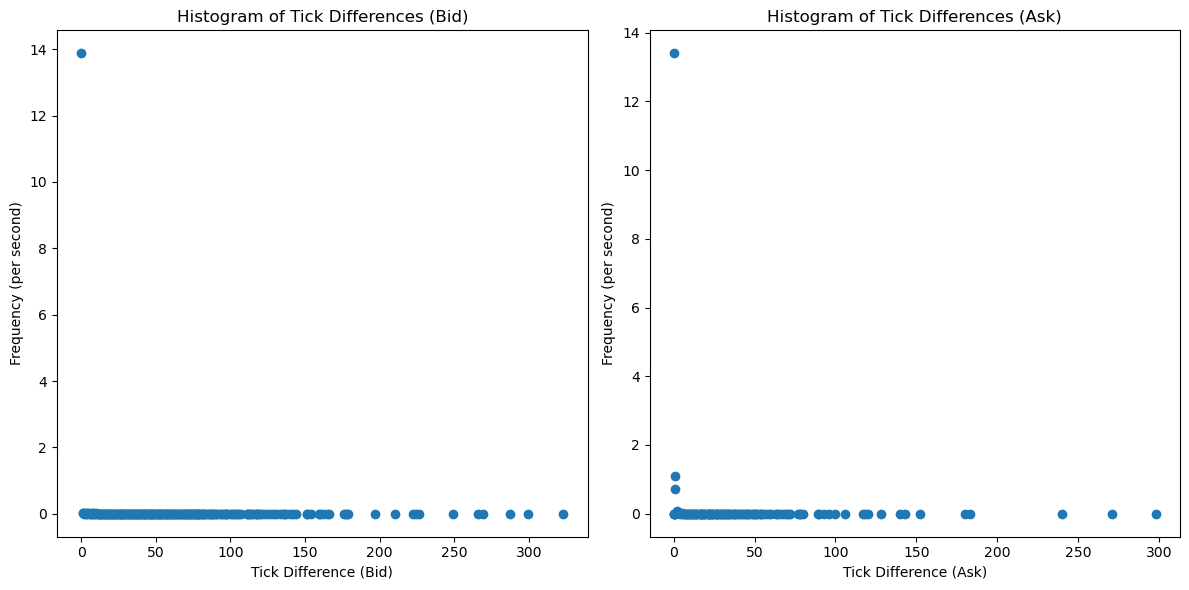

In [123]:
#plot
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Bid 히스토그램
axes[0].scatter(bid_unique_values[start_bid:], bid_counts[start_bid:] /time_diff)
axes[0].set_xlabel('Tick Difference (Bid)')
axes[0].set_ylabel('Frequency (per second)')
axes[0].set_title('Histogram of Tick Differences (Bid)')

# Ask 히스토그램
axes[1].scatter(ask_unique_values[start_ask:], ask_counts[start_ask:] / time_diff)
axes[1].set_xlabel('Tick Difference (Ask)')
axes[1].set_ylabel('Frequency (per second)')
axes[1].set_title('Histogram of Tick Differences (Ask)')

plt.tight_layout()
plt.show()

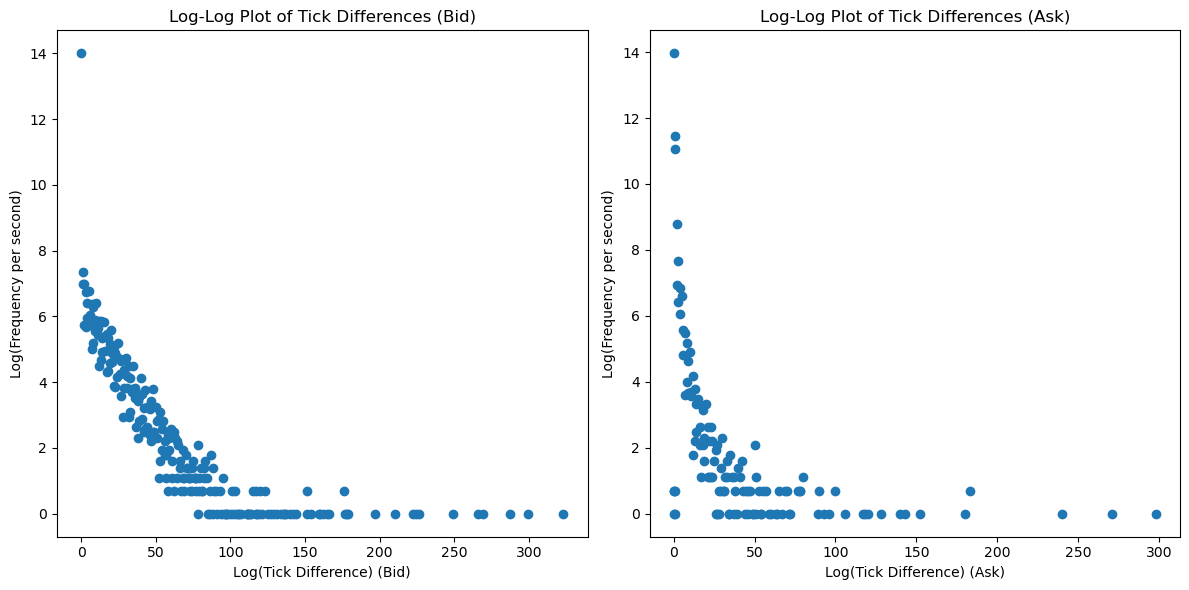

In [126]:
# Log-log plot
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Bid log-log plot
axes[0].scatter(bid_unique_values[start_bid:] , np.log(bid_counts[start_bid:]))
axes[0].set_xlabel('Log(Tick Difference) (Bid)')
axes[0].set_ylabel('Log(Frequency per second)')
axes[0].set_title('Log-Log Plot of Tick Differences (Bid)')

# Ask log-log plot
axes[1].scatter(ask_unique_values[start_ask:], np.log(ask_counts[start_ask:]))
axes[1].set_xlabel('Log(Tick Difference) (Ask)')
axes[1].set_ylabel('Log(Frequency per second)')
axes[1].set_title('Log-Log Plot of Tick Differences (Ask)')

plt.tight_layout()
plt.show()